**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Logistic Regression and Neural networks in music classifications* 

## Abstract

This report describes the process of improving the accuracy of a classifier for music. The methods used in improving  the classifier involve examining different preprocessing techniques, finding good features, finding good classifiers and cross validation. The conclusion of this report is that a Single Layer Perceptron classifier yields the best results for the accuracy and log-loss of the classification, but that it is only performs marginally better than a Logistic regression classifier.

_Note to reader: The code included in this project must be executed in order from top to bottom. Othervise the code might misbehave._



## 1. Introduction

Classification, in machine learning, is the problem of assigning labels to observations. There are generally two types of classification problems. These are, unsupervised and supervised classification problems. [1]
The classification problem being solved in this paper is the classification of songs based on genre. This is a supervised classification problem because the data includes the labels of the observations. [1] In total there are ten different music genre labels and thus ten different classifications.
This particular supervised classification problem could be particularly important for companies as last.fm and Spotify because they make recommendations based on people's music preferences. Thousands of songs, which might not be properly labeled, are uploaded each day to these platforms, so recommending these songs to the right people could be hard without some machine learning classification. The analysis of how a classifier works can also give insight into how different music genres related, which could also be of use to the aforementioned companies [12].
My personal goal for this project is to gain greater knowledge in different classification methods and get field experience in using them. The competition element of this problem (being able to compare your classifier to other students), also adds extra excitement, and motivates me to both study and perform well in this task.
The three main methods used in making a model for the classifier involve, preprocessing, finding good features and samples, finding good classifiers and validating the models tried. To determine the accuracy of the different models tested, cross validation is used as well as evaluating the classifications on Kaggle where the classifications can be compared with the true labels of the test data.
The two classifiers which which yielded the best results were logistic regression and a single layer perceptron neural network.  

The packages used in this project include: scipy[14], Numpy[4], pandas[5],sklearn[11] and matplotlib[13].

## 2. Data analysis

In this section the data is vizulaised using different techniques. The problems observed from the vizualised data are also briefly discussed.

To get some basic sense of the data being used, we'll start by plotting the data according to its division to rhythm , chroma and mfcc data subsets. The features will be plotted on the x-axis, and their observed value on the y-axis.

In [84]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt


In [85]:
# Load the data and cleanup
df1 = pd.read_csv("./test_data.csv", header=None)
df2 = pd.read_csv("./train_data.csv", header=None)
df3 = pd.read_csv("./train_labels.csv", header=None)
mat = df3.values.flatten()
train_rythm_data = df2.loc[:, 0:168-1]
train_chroma_data = df2.loc[:, 168:168 + 48 - 1]
train_mfcc_data = df2.loc[:, 168 + 48:]
test_rythm_data = df2.loc[:, 0:168-1]
test_chroma_data = df2.loc[:, 168:168 + 48 - 1]
test_mfcc_data = df2.loc[:, 168 + 48:]

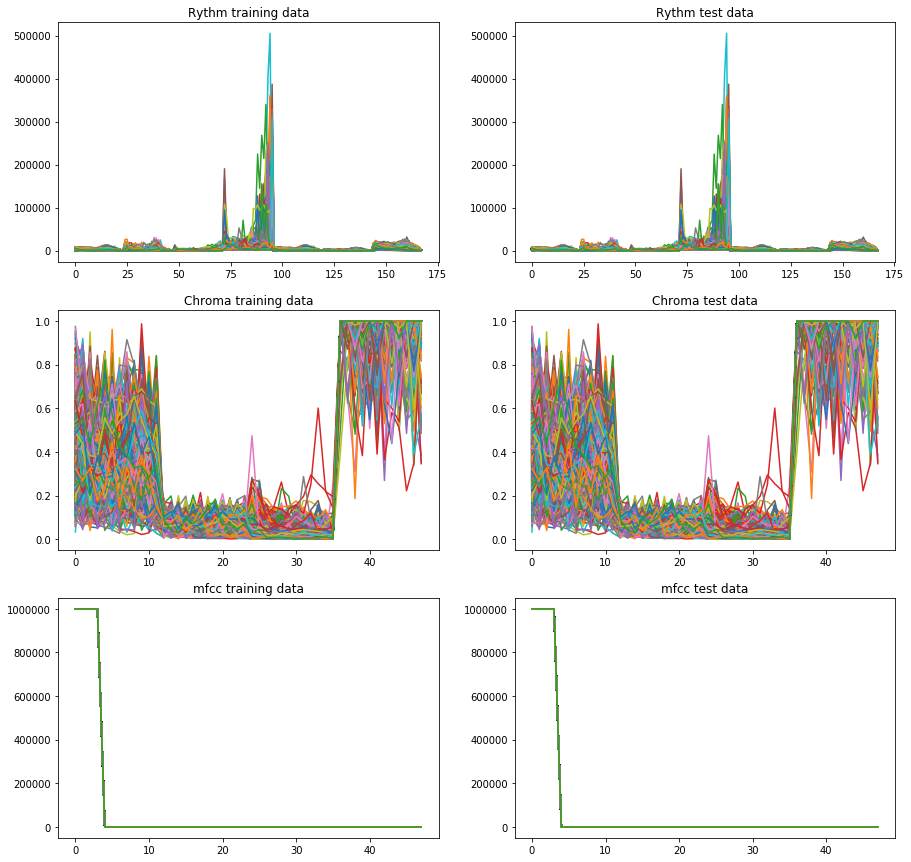

In [86]:
#Analysis of the input data
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes[0, 0].plot(train_rythm_data.values.T)
axes[1, 0].plot(train_chroma_data.values.T)
axes[2, 0].plot(train_mfcc_data.values.T)
axes[0, 1].plot(test_rythm_data.values.T)
axes[1, 1].plot(test_chroma_data.values.T)
axes[2, 1].plot(test_mfcc_data.values.T)
axes[0, 0].set_title('Rythm training data')
axes[1, 0].set_title('Chroma training data')
axes[2, 0].set_title('mfcc training data')
axes[0, 1].set_title('Rythm test data')
axes[1, 1].set_title('Chroma test data')
axes[2, 1].set_title('mfcc test data')
plt.show()

We can see that the rhythm data is not very well scaled as most of the features in it have values well below 50000 while some of the data are more than 50 times larger. This would indicate that some feature selection or data scaling could be motivated here.  

The chroma data seems to be well scaled between zero and one, but there seems to be observations, which quite heftily deviate from the rest of the values, which could mean the data has bad observations (songs) that aren't characteristic for any label. 

The beginning of the mfcc data also show features which don't seem to conway that much information as they all have the same value. This could also mean that feature selection has to be done on the mfcc data.


### Loading analysis and selecting good features

Analysis of the loadings in Principal Component Analysis (PCA) can be used to analyze how features affect the main variation in the data. The loading vector can be interpreted both by their magnitude and their direction. Loadings with the same general direction, will correlate highly, where as loadings with opposite directions will not correlate at all. The magnitude of the loadings indicate how much a feature contributes to the total variation in the data. Features corresponding to loading components with a very low magnitude (close to 0), thus mean that they do not convay much information, and could thus be removed from the data. [9]

### Score analysis and choosing good observations
The scores of PCA can be used to to detect outlier or bad observations in the data. Plotting the scores of the first principal component against the scores of the second principal component should form clear clusters, where points outside these clusters could be considered outliers which makes the classification worse.  
The components of the score vectors correspond to the different observations, so we should remove the observations that correspond to score components which don't fit any cluster. [9]

Explained variance: [0.33459381 0.26706892 0.1193355  0.08090545 0.04453306]


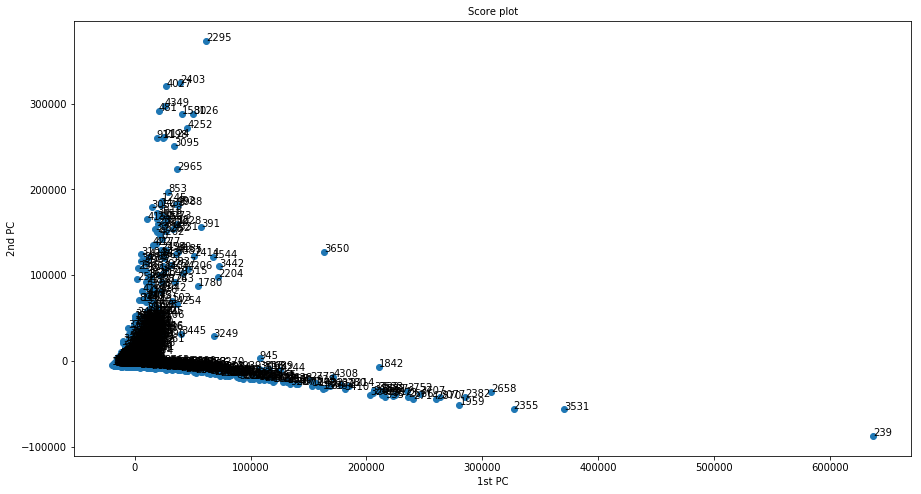

In [87]:
X = df2.values
y = df3.values

fig, ax = plt.subplots(figsize=(15,8))
scores, loading = run_pca(X)
ax.scatter(scores.T[0],scores.T[1])
ax.set_xlabel('1st PC', fontsize=10)
ax.set_ylabel('2nd PC', fontsize=10)
ax.set_title('Score plot', fontsize=10)
for i in range(X.shape[0]):
    ax.annotate(str(i), (scores.T[0][i], scores.T[1][i]))

From the plot above we can see that most of the data are clustered in seemily two directions, points not included in these clusters could be considered outlier data points. Observations indexed by 3650, 3249, 1842 and 239, could from the basis of this plot be considered outliers and removed from the training data.  

## Class distribution

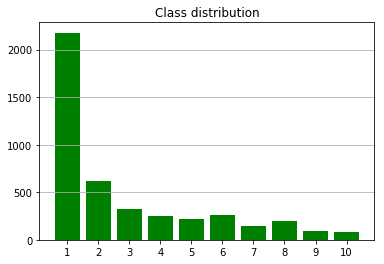

In [88]:
import collections

amounts = collections.Counter(y.flatten())
fig, ax = plt.subplots()
ax.bar(list(amounts.keys()), amounts.values(), color='g')
ax.set_xticks(list(range(1,11)))
ax.set_title('Class distribution')
plt.gca().yaxis.grid(True)
plt.show()

The class distribution shows that the number of samples for the label indexed by one far outnumbers the number of samples for any other label. If we expect the test data to have a similar class distribution we don't have a problem, but if however the test data has, for example, a uniform class distribution, we are in trouble as we are overfitting our classifier for the class indexed by one.  [2]

### Dimensionality

The high dimensionality of the data definitely makes the analysis of the data more tedious, but should not make it by any means impossible, thanks to impart the dimensionality reduction technique PCA. [9]

## 3. Methods and experiments

## Preprocessing

### Scaling

The _preprocessing_ package by sklearn was used to scale the data.[5] The scalers MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler and QuantileTransformer were tested validation scheme described above.

### Feature selection

The mfcc data visualised in section 2 showed that there were some features whose observations had a constant value, which means that we can't make any classifications based on them. Removing theses features should thus result in better classification.

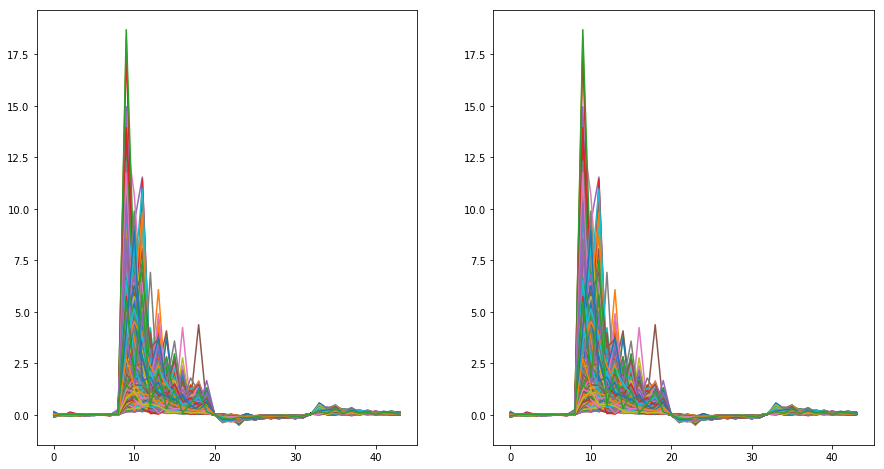

In [89]:
df2 = df2.drop(columns=[216, 217, 218, 219])
df1 = df1.drop(columns=[216, 217, 218, 219])
train_mfcc_data = df2.loc[:, 168 + 48:]
test_mfcc_data = df2.loc[:, 168 + 48:]
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].plot(train_mfcc_data.values.T)
axes[1].plot(test_mfcc_data.values.T)
plt.show()

After removing the first features in the mfcc data we can already see more variation in the data, which we want. There are however some features which have clearly larger values than the rest of the features. These could be outliers, but could just as well be really good classifiers of each music genre and just take large numbers, we'll thus test how good our classification is with and without these features. Different scaling methods will also be tried to alleviate the problem with these large values.

To find good and bad features using PCA we plot the loadings. First the loadings of the rythm pattern, chroma's and MFCC's were analyzed separately.
Then the loadings of each statistic were analyzed, or in total 7 + 4 + 4 = 15 figures. A few of those plots are shown below.

Explained variance: [0.7505858  0.09510292 0.04770303 0.02431286 0.02109188]
Explained variance: [0.55620805 0.11254782 0.09555876 0.04222416 0.03109925]


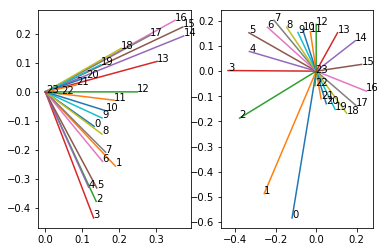

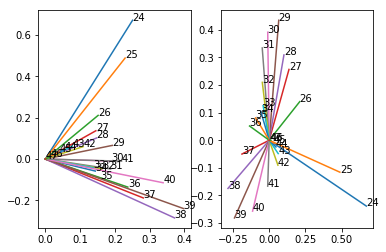

In [90]:
from sklearn.decomposition import PCA

def run_pca(X_train):
    pca = PCA(n_components=5, svd_solver='full')
    scores = pca.fit_transform(X_train)
    loading = pca.components_
    print("Explained variance: {0}".format(pca.explained_variance_ratio_))
    return scores, loading

def test_rythm(data, start=0, end=7):
    for i in range(start, end):
        labels = data.loc[:, i * 24:(i + 1) * 24 - 1].columns
        f1 = data.loc[:, i * 24:(i + 1) * 24 - 1].values
        scores, loadings = run_pca(f1)
        plot_loadings(f1, loadings, labels)
        
def plot_loadings(X, loading, lab_pos):
    fig, axes = plt.subplots(1, 2)

    ax = axes[0]

    # ax.scatter(loading[0], loading[1])
    for i in range(loading.shape[1]):
        ax.plot([0, loading[0][i]], [0, loading[1][i]])

    for i in range(X.shape[1]):
        ax.annotate(str(lab_pos[i]), (loading[0][i], loading[1][i]))

    ax = axes[1]
    # ax.scatter(loading[1], loading[2])
    for i in range(loading.shape[1]):
        ax.plot([0, loading[1][i]], [0, loading[2][i]])

    for i in range(X.shape[1]):
        ax.annotate(str(lab_pos[i]), (loading[1][i], loading[2][i]))

test_rythm(train_rythm_data,0,2)
plt.show()

Lastly each statistic was compared using training data of each of the 10 labels. This was done with the hypothesis that useless features would be universal for classifying each of the labels, and the each classifier had a distinct loading pattern to indicate that the combination of features yielded label specific outcomes.

Explained variance: [0.75878859 0.09507304 0.04371442 0.02215913 0.02105122]
Explained variance: [0.77417789 0.0848298  0.03561269 0.02000686 0.01707564]


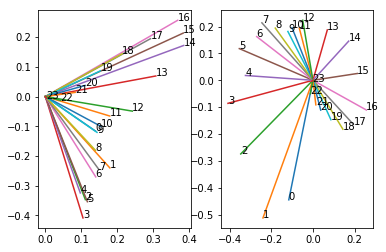

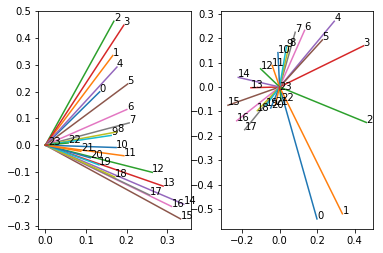

In [92]:
def i_for(i):
    # Get indicies of observations where label is equal to i.
    return np.where(mat == i)

l = [1,8] #data of labels to be plotted
for i in l:
    test_rythm(train_rythm_data.iloc[i_for(i)],0,1)

### Data selection
Different score plots from subsets of the data will be analyzed in order to find outlier observations in the training set.

### Weiging the samples

To alleviate the possible problems from the class distribution I tried weighing the training samples with a with the scheme  
  

\begin{equation}
training\_sample_i =1 - \frac{number\_of\_samples\_in\_class\_of(training\_sample_i)}{number\_of\_samples\_total}
\end{equation}

in order to to give a larger weight to the samples of which there were less of, and smaller weights to samples there where more of.

### Classifiers

Two classifiers are will be tested. Logistic regression, as it has been proven to work in these types of problems during the course. The other classifier is Multi-layer perceptron neural networks, as I find it interseting and wanted to see how well it would work in this problem. A Multi-layer perceptron neural network has the added benefit of being able to learn  non-linear models.[11][6][7][8]

### Validation

The main methodology used in developing the model is displayed in the figure below. 

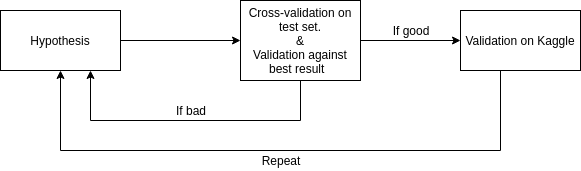

In [93]:
from IPython.display import Image
Image(filename='mlbp-methodology.png') 

The process starts with coming up with a hypothesis of how the model could be improved. Once a hypothesis is made the hypothesis is validated with cross-validation on the test set and by comparing it to the best classification found thus far.  
I compared the new hypothesised best classification the best classification thus far as the improvements gained when improving the model were always very small, which means that the new hypothesised best classification should diverge, very little, from the true best classificaiton thus far. I generally disregarded new hypothesised best classifications that had a score less than 0.8, but agree that this type of validation isn't very reliable as the best classifications where in the 70% accuracy range which means that the score of the new new hypothesised best classification could be less than 0.8 while still improving on the current model. I however approached this problem by actively trying to make as small improvements as possible, so that small hypothesised classifications scores would be less likely to indicate an improvement on the model.  
Together with cross-validation on the test set, the probability of discarding new good models should be relatively small.


## 4. Results

### What worked

The scaling method which proved to yield the best accuracy and log-loss proved to be the Quantile scaler which transforms each feature to follow a uniform distribution.

The removal of the first feature in the mfcc subset was also successful in increasing accuracy and reducing log-loss. Additionally the plotting of loadings, in order to find bad features, proved that the removal of the features indexed by 71, 72, 88, 89, 90, 91, 92, 93, 94, 95, 216, 217, 218 and 219 resulted in a better classification. The log-loss however always had a better result when, in addition to the aforementioned features, the features 23, 47, 119 and 143, which had loadings very close to zero, where also removed.  

The use of a Single Layer perceptron network also gave the best classification accuracy (0.66632). It was however only marginally better than the classification using Logistic regression, which had an accuracy of (0.66327). The MLPClassifier was tested with multiple different layer configurations ((100,100),(200,200), (200,200,200), (50,20), (50,10), (20,10), (20,10,10)) but the best performance was acquired using only a single layer with 100 neurons, which would indicate that the data is linearly separable.

The removal of observations with the help of score plots did not improve the the accuracy of the classification when using a Single Layer Perceptron classifier but did improve the accuracy when using logistic regression. The log-loss metric was also improved using both classifiers on Kaggle.


### What didn't work

I tried to use PCA reduce the feature space and only use the components which explained most of the variance in the data, in order to remove random variation in the data if there was any. The dimension reduction however only resulted in a worse classification accuracy.

The weighing of samples didn't improve the classification accuracy, but made it significantly worse. This could indicate that the test set has a class distribution similar to the training set's. It could however also just mean that my weighing of the samples wasn't any good.   
I also tried simply removing some of the samples labeled "1" form the training set of the classifier, but this also resulted in a significantly worse classification accuracy.


From the plot above we can see that most of the data are clustered in seemily two directions, points not included in these clusters could be considered outlier data points. Observations indexed by 3650, 3249, 1842 and 239, could from the basis of this plot be considered outliers and removed from the training data.  


The following code includes a particular hypothesised best model which also happens to have resulted in the best classification accuracy.

The feature and training data, scaler, classifier, and classifier settings, were changed based on the discussion in section 3 when trying out a new models.

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

df1 = pd.read_csv("./test_data.csv", header=None)
df2 = pd.read_csv("./train_data.csv", header=None)
df3 = pd.read_csv("./train_labels.csv", header=None)
df4 = pd.read_csv("./best.csv")

## Preprocessing

#Feature selection
df2 = df2.drop(columns=[
    71, 72, 88, 89, 90, 91, 92, 93, 94, 95, 216, 217, 218, 219, 
    #23, 47, 119, 143 #included for best logloss
])
df1 = df1.drop(columns=[
    71, 72, 88, 89, 90, 91, 92, 93, 94, 95, 216, 217, 218, 219, 
    #23, 47, 119, 143 #included for best logloss
])

# Training data selection
df2 = df2.drop([1558, 3820, 3411, 1842, 239, 4308, 3008, 3119, 1763, 4296, 3423, 1073, 3650])
df3 = df3.drop([1558, 3820, 3411, 1842, 239, 4308, 3008, 3119, 1763, 4296, 3423, 1073, 3650])

y = df3.values
y_best = df4['Sample_label'].values # Best model found thus far

#Scaling
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)

X = df2.values
X_t = df1.values 
quantile_transformer.fit(X)
X = quantile_transformer.transform(X)
X_t = quantile_transformer.transform(X_t)

def predLog(X, y, state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=state)
    y_pred, score, prob = classifier(X_train, y_train, X_test, y_test)
    print("Prediction score {0}: {1:.3}".format(state,score))
    return y_pred, score


def crossValidation(X,y):
    accs = []
    for i in range(10):
        ys, ac = predLog(X, y, i)
        accs.append(ac)
    print("Mean score: {0}".format(np.mean(accs)))
    
def classifier(X_train, y_train, X_test, y_test):
    #clf = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000, tol=1e-6) # best logistic regresion
    clf = MLPClassifier(alpha=1, max_iter=300)
    clf.fit(X_train, y_train.flatten())
    y_pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)
    score = clf.score(X_test, y_test)
    return y_pred, score, prob

def predMLP(X_train, y_train, X_test, y_test):
    y_pred, score, prob = classifier(X_train, y_train, X_test, y_test)
    print("Accuracy compared to best prediction: {0}".format(score))
    return y_pred, prob

#Validation
crossValidation(X, y)
new_classification, prob = predMLP(X, y, X_t, y_best)

Prediction score 0: 0.655
Prediction score 1: 0.655
Prediction score 2: 0.668
Prediction score 3: 0.663
Prediction score 4: 0.648
Prediction score 5: 0.666
Prediction score 6: 0.664
Prediction score 7: 0.664
Prediction score 8: 0.644
Prediction score 9: 0.661
Mean score: 0.6587743732590529
Accuracy compared to best prediction: 0.9271088019559902


### Kaggle performance

This model gave the best accuracy of **0.66632** and the best log-loss of **0.16637**.  
_If MLPClassifier is exchanged for the Logistic Regression classifier the resulting classification accuracy was **0.66327**._

### Confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix
labels = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', ]

#Confusion matrix for using only test data and test labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
new_classification, score, prob = classifier(X_train, y_train, X_test, y_test)
cm = confusion_matrix(y_test,new_classification)
df = pd.DataFrame(cm)
df.columns = labels
df['class'] = labels
df = df.set_index('class')
print(df)

         1    2   3   4   5   6  7   8   9  10
class                                         
1      648   38   3   8   7  21  0  11   1   0
2       61  112   4   2   0   6  0   0   2   0
3       17   10  69   1   1   7  0   0   2   0
4       22   11   1  36   2   7  0   0   1   0
5       38    2   2   0  19   7  0   2   1   0
6       38    3   4   5   1  35  0   2   1   0
7       20    1   3   3   4   3  0   3   1   0
8       42    0   1   0   2   1  1  12   0   0
9        7    1  10   0   2   6  0   1  10   0
10      22    0   1   2   3   0  0   2   0   1


## 5. Discussion/Conclusions

The confusion matrix reveals the many observations are mislabeled to the label 1. This could be caused by the fact that we use much more observations with the label 1 to train the classifier.  

I spent quite a lot of time testing different models and analyzing the scores and loadings of the data. My accuracy is however only about 70% and I think that I could, if i had better understanding of the underlying data, have gotten better results. It could however be that, based on the class distribution of the training set, it is impossible to gain a very good classification accuracy, but this depends of course on the class distribution of the test set.  
I would have liked to also spend more time in understanding Multi-layer perceptron networks as my shallow understanding of it basically led me just to test different configurations of it using trial and error.  

How good a classification accuracy can be, depends on the available data, and the classification models application.[10] If for example we can we can 70% of the time can provide a user with a relevant song suggestion, I'd argue that could be considered a good result. If however the classification accuracy of songs was, for example,  somehow linked to advertising, the accuracy of 70% might not be very good if false classifications resulted in monetary costs.  

In conclusion this project was extremely fun, and I learned a lot from participating in it. I cannot however say if it answer any particular question I had, as I didn't have any particular question I wanted answered.

## 6. References

1. Statistical classification: https://en.wikipedia.org/wiki/Statistical_classification
2. Machine Learning: Basic Principles, Alexander Jung: https://arxiv.org/abs/1805.05052
3. Pandas: https://pandas.pydata.org/
4. NumPy: http://www.numpy.org/
5. Preprocessing data http://scikit-learn.org/stable/modules/preprocessing.html
6. Classifier comparison http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
7. Logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
8. Multi-layer perceptron nerual network http://scikit-learn.org/stable/modules/neural_networks_supervised.html
9. Kevin Dunn. Process Improvement Using Data. 2018. URL https://learnche.org/pid/PID.pdf?419-67d8. Release 419-67d8.
10. Sandro Saitta. What is a good classification accuracy in data mining?
http://www.dataminingblog.com/what-is-a-good-classification-accuracy-in-data-mining/
11. Scikit learn developers. scikit-learn user guide, November 21, 2017. URL http://
scikit-learn.org/0.19/_downloads/scikit-learn-docs.pdf. Release 0.19.1.
12. How Spotify Discovers the Genres of Tomorrow. https://artists.spotify.com/blog/how-spotify-discovers-the-genres-of-tomorrow
13. matplotlib. https://matplotlib.org/
14. scipy. https://www.scipy.org/